# Caustics

In [1]:
import os
import numpy as np
import imageio, cv2

# the higher PRECISION, the bigger the file
# PRECISION = 4  # debugging
# PRECISION = 10 # good quality
PRECISION = 12 # very good quality
# PRECISION = 14 # for production

# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass

@dataclass
class init:
    figpath: str = '2024-07-25_caustique' # Folder to store images
    phi: float = 1.61803 # beauty is gold
    tag: str = 'caustique' # Tag
    ext: str = 'png' # Extension for output
    nx: int = 5*2**PRECISION # number of pixels (vertical)
    ny: int = 5*2**PRECISION # number of pixels (horizontal)
    nframe: int = 1 # number of frames
    bin_dens: int = 2 # relative bin density
    bin_spectrum: int = 1 # bin spacing in spectrum (lower is more CPU)
    seed: int = 2024 # seed for RNG
    H: float = 20.0 # depth of the pool
    variation: float = .20 # variation of diffraction index: http://www.philiplaven.com/p20.html 1.40 at 400 nm and 1.37 at 700nm makes a 2% variation
    scale: float = .95*2**PRECISION # period in pixels
    B_sf: float = 1.00 # bandwidth in sf
    V_Y: float = 0.3 # horizontal speed
    V_X: float = 0.3 # vertical speed
    B_V: float = 1.0 # bandwidth in speed
    zmin: float = 0.10 # gradient of wave height
    # theta: float = 2*np.pi*(2-1.61803) # angle with the horizontal
    theta: float = np.pi/2 # angle with the horizontal
    B_theta: float = 60*np.pi/180 # bandwidth in theta
    min_lum: float = .01 # global diffusion level for the rendering giving the pedestal value
    n_bits: int = 16 # bits to save images
    gamma: float = 2.4 # Gamma exponant to convert luminosity to luminance
    fps: float = 18 # frames per second
    multispectral: bool = True # Compute caustics on the full spectrogram.
    cache: bool = True # Cache intermediate output.
    verbose: bool = False # Displays more verbose output.
    do_display: bool = False # Displays images in notebook.
    do_recompute: bool = True # Restart each computation    

In [2]:
opt = init()
print(f'Saving our simulations in={opt.figpath}')

Saving our simulations in=2024-07-24_caustique


In [3]:
# if opt.nframe==1: opt.ext = 'png'

In [4]:
from pprint import pprint
pprint(opt)

init(figpath='2024-07-24_caustique',
     phi=1.61803,
     tag='caustique',
     ext='png',
     nx=5120,
     ny=5120,
     nframe=1,
     bin_dens=2,
     bin_spectrum=1,
     seed=2024,
     H=20.0,
     variation=0.2,
     scale=870.4,
     B_sf=1.25,
     V_Y=0.3,
     V_X=0.3,
     B_V=1.0,
     zmin=0.2,
     theta=1.5707963267948966,
     B_theta=1.0471975511965976,
     min_lum=0.1,
     n_bits=16,
     gamma=2.4,
     fps=18,
     multispectral=True,
     cache=True,
     verbose=False,
     do_display=False,
     do_recompute=True)


In [5]:
screen_size = 100 # cm
cm_by_inch = 2.54
inches = screen_size/cm_by_inch
dpi = opt.nx // opt.bin_dens / inches
print(f'Screen size={screen_size}cm, dpi={dpi:.0f}dpi')

Screen size=100cm, dpi=65dpi


## utilities

Transfoming a sequence of PNG frames into gif or mp4:

In [6]:
def make_gif(gifname, fnames, fps, do_delete=True):
    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for fname in fnames:
            writer.append_data(imageio.imread(fname))

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return gifname

# https://moviepy.readthedocs.io/en/latest/getting_started/videoclips.html#imagesequenceclip
def make_mp4(mp4name, fnames, fps, do_delete=True):
    import moviepy.editor as mpy
    clip = mpy.ImageSequenceClip(fnames, fps=fps)
    clip.write_videofile(mp4name, fps=fps, codec='libx264', verbose=False, logger=None)
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return mp4name


Utilities to compute the spectrum of the blue sky and convert them later to RGB values (check out https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for details)

In [7]:
from lambda2color import Lambda2color, xyz_from_xy

# borrowed from https://github.com/gummiks/gummiks.github.io/blob/master/scripts/astro/planck.py
def planck(wav, T):
    import scipy.constants as const
    c = const.c # c = 3.0e+8
    h = const.h # h = 6.626e-34
    k = const.k # k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def scattering(wav, a=0.005, p=1.3, b=0.45):
    """
    b is  proportionate  to  the  column  density  of  aerosols
    along  the  path  of  sunlight,  from  outside  the  atmosphere
    to  the  point  of  observation
    
    see https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for more details

    """
    # converting wav in µm:
    intensity = np.exp(-a/((wav/1e-6)**4)) # Rayleigh extinction by nitrogen
    intensity *= (wav/1e-6)**-4
    intensity *= np.exp(-b/((wav/1e-6)**p)) # Aerosols
    return intensity

## computing the caustics

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import shutil
import hashlib
import MotionClouds as mc

class Caustique:
    def __init__(self, opt):
        """
        Image coordinates follow 'ij' indexing, that is,
        * their origin at the top left,
        * the X axis is vertical and goes "down",
        * the Y axis is horizontal and goes "right".

        """
        self.mc = mc
        self.ratio = opt.ny/opt.nx # ratio between height and width (>1 for portrait, <1 for landscape)
        X = np.linspace(0, 1, opt.nx, endpoint=False) # vertical
        Y = np.linspace(0, self.ratio, opt.ny, endpoint=False) # horizontal
        self.xv, self.yv = np.meshgrid(X, Y, indexing='ij')
        self.opt = opt
        # https://stackoverflow.com/questions/16878315/what-is-the-right-way-to-treat-python-argparse-namespace-as-a-dictionary
        self.d = vars(opt)
        os.makedirs(self.opt.figpath, exist_ok=True)
        self.cachepath = os.path.join('/tmp', self.opt.figpath)
        if opt.verbose: print(f'{self.cachepath=}')
        os.makedirs(self.cachepath, exist_ok=True)

        # a standard white:
        # illuminant_D65 = xyz_from_xy(0.3127, 0.3291), 
        illuminant_sun = xyz_from_xy(0.325998, 0.335354)
        # color conversion class
        self.cs_srgb = Lambda2color(red=xyz_from_xy(0.64, 0.33),
                               green=xyz_from_xy(0.30, 0.60),
                               blue=xyz_from_xy(0.15, 0.06),
                               white=illuminant_sun)
        self.wavelengths = self.cs_srgb.cmf[:, 0]*1e-9
        self.N_wavelengths = len(self.wavelengths)
        # multiply by the spectrum of the sky
        intensity5800 = planck(self.wavelengths, 5800.)
        scatter = scattering(self.wavelengths)
        self.spectrum_sky = intensity5800 * scatter
        self.spectrum_sky /= self.spectrum_sky.max()

    def wave(self):
        filename = f'{self.cachepath}/{self.opt.tag}_wave.npy'
        if os.path.isfile(filename) and not(self.opt.do_recompute):
            z = np.load(filename)
        else:
            # A simplistic model of a wave using https://github.com/NeuralEnsemble/MotionClouds
            fx, fy, ft = mc.get_grids(self.opt.nx, self.opt.ny, self.opt.nframe)
            env = mc.envelope_gabor(fx, fy, ft, V_X=self.opt.V_Y, V_Y=self.opt.V_X, B_V=self.opt.B_V,
                                    sf_0=1./self.opt.scale, B_sf=self.opt.B_sf/self.opt.scale,
                                    theta=self.opt.theta, B_theta=self.opt.B_theta)
            z = mc.rectif(mc.random_cloud(env, seed=self.opt.seed))
            if self.opt.cache: np.save(filename, z)
        return z * np.linspace(self.opt.zmin, 1., self.opt.nx)[:, None, None]

    def transform(self, z_, modulation=1., edge_order=2):
        xv, yv = self.xv.copy(), self.yv.copy()

        # dzdx = z_ - np.roll(z_, 1, axis=0)
        # dzdy = z_ - np.roll(z_, 1, axis=1)

        # https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
        # dzdx = np.gradient(z_, axis=0, edge_order=edge_order)
        # dzdy = np.gradient(z_, axis=1, edge_order=edge_order)
        dzdx, dzdy = np.gradient(z_, edge_order=edge_order)

        xv = xv + modulation * self.opt.H * dzdx
        yv = yv + modulation * self.opt.H * dzdy

        xv = np.mod(xv, 1)
        yv = np.mod(yv, self.ratio)

        return xv, yv

    def plot(self, z, image=None, do_color=True, dpi=dpi):
        """
        
        dpi: output resolution - sets the figure size as we ensure there is a one to one correspondance between pixels in the data and the output image
        """

        # output filename        
        md5 = hashlib.sha224((self.opt.figpath + self.opt.tag).encode()).hexdigest()[:8] # an unique identifier for future tagging
        output_filename = f'{self.opt.figpath}/{self.opt.tag}_{md5}.{self.opt.ext}'
        if os.path.isfile(output_filename) and not(self.opt.do_recompute):
            return output_filename
        else:
            # 1/ do the raytracing of image through z:
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

            # a fixed image in degree of contrast (from 0=black to 1=white)
            if image is None: image = np.ones((self.opt.nx, self.opt.ny))

            #hist = self.do_raytracing(z)
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

            subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)

            if self.opt.multispectral:

                #image_rgb = self.cs_srgb.spec_to_rgb(hist)
                image_rgb = np.zeros((self.opt.nx//self.opt.bin_dens,  self.opt.ny//self.opt.bin_dens, 3, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    for i_wavelength in trange(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum):
                        modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths
                        xv, yv = self.transform(z[:, :, i_frame], modulation=modulation)
                        hist_, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                                     bins=[binsx, binsy],
                                                     weights=image.ravel(),
                                                     range=[[0, 1], [0, self.ratio]],
                                                     density=True)

                        # we convert the spectrum into a color
                        spec = np.zeros((self.N_wavelengths))
                        spec[i_wavelength] = 1
                        rgb = self.cs_srgb.spec_to_rgb(spec)
                        rgb *= self.spectrum_sky[i_wavelength]
                        # we add the color to the image
                        image_rgb[:, :, :, i_frame] += hist_[:, :, None] * rgb[None, None, :]

                image_rgb -= image_rgb.min()
                image_rgb /= image_rgb.max()
            else:
                hist = np.zeros((binsx, binsy, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    xv, yv = self.transform(z[:, :, i_frame])
                    hist_, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                                        bins=[binsx, binsy],
                                                        range=[[0, 1], [0, self.ratio]],
                                                        density=True)
                #hist /= hist.max()

            # 2/ transform light into image:
            fnames = []
            for i_frame in trange(self.opt.nframe):
                fig, ax = plt.subplots(figsize=(self.opt.ny/self.opt.bin_dens/dpi, self.opt.nx/self.opt.bin_dens/dpi), subplotpars=subplotpars)
                if self.opt.multispectral:
                    image_array = image_rgb[:, :, :, i_frame] ** (1/self.opt.gamma)
                    ax.imshow(image_array, vmin=0, vmax=1)
                else:
                    if do_color:
                        bluesky = np.array([0.268375, 0.283377]) # xyz
                        sun = np.array([0.325998, 0.335354]) # xyz
                        # ax.pcolormesh(edge_y, edge_x, hist[:, :, i_frame], vmin=0, vmax=1, cmap=plt.cm.Blues_r)
                        # https://en.wikipedia.org/wiki/CIE_1931_color_space#Mixing_colors_specified_with_the_CIE_xy_chromaticity_diagram
                        L1 = 1 - hist[:, :, i_frame]
                        L2 = hist[:, :, i_frame]
                        image_denom = L1 / bluesky[1] + L2 / sun[1]
                        image_x = (L1 * bluesky[0] / bluesky[1] + L2 * sun[0] / sun[1]) / image_denom
                        image_y = (L1 + L2) / image_denom 
                        image_xyz = np.dstack((image_x, image_y, 1 - image_x - image_y))
                        image_rgb = self.cs_srgb.xyz_to_rgb(image_xyz)
                        image_L = (self.opt.min_lum + (1-self.opt.min_lum)* L2) ** (1/self.opt.gamma)
                        image_array = image_L[:, :, None]*image_rgb
                        ax.imshow(image_array, vmin=0, vmax=1)
                    else:
                        ax.imshow(1-image_L, vmin=0, vmax=1)

                fname = f'{self.cachepath}/{self.opt.tag}_frame_{i_frame:04d}.png'
                
                # fig.savefig(fname, dpi=dpi)
                np_dtype = np.uint8 if self.opt.n_bits==8 else np.uint16
                # imageio.imsave(fname, image_array.astype(np_dtype), dpi=dpi, extension=opt.ext)
                cv2.imwrite(fname, (image_array*(2**self.opt.n_bits-1)).astype(np_dtype))
                fnames.append(fname)
                plt.close(fig)

            if self.opt.nframe==1:
                shutil.copyfile(fname, output_filename)
                return output_filename
            else:
                if self.opt.ext == 'gif':
                    return make_gif(output_filename, fnames, fps=self.opt.fps)
                else:
                    return make_mp4(output_filename, fnames, fps=self.opt.fps)

    def show(self, output_filename, width=1024):
        from IPython.display import HTML, Image, display
        if self.opt.nframe==1:
            # display(Image(url=output_filename.replace(self.opt.ext, 'png'), width=width))
            display(Image(url=output_filename, width=width))
        else:
            if self.opt.ext == 'gif':
                return display(Image(url=output_filename, width=width))
            else:
                #import moviepy.editor as mpy
                #return mpy.ipython_display(output_filename, width=width)
                # https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L858
                opts = ' loop="1" autoplay="1" controls '
                html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')
                html.reload()
                return display(html)

<>:193: SyntaxWarning: invalid escape sequence '\>'
<>:193: SyntaxWarning: invalid escape sequence '\>'
/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_21826/1923257970.py:193: SyntaxWarning: invalid escape sequence '\>'
  html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')


# a simple caustics

## generating the caustics

In [9]:
c = Caustique(opt)
z = c.wave()
z.shape

(5120, 5120, 1)

In [10]:
def generate_image(nx, ny, periods=6.25, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    # image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image = (image>=1) * 1.
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)

In [11]:
c = Caustique(opt)
output_filename = c.plot(z, image)

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


In [12]:
c.show(output_filename)

# exploring parameters

In [13]:
N_scan = 9
base = 2

## water depth

In [14]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


H = 10.000 -> output_filename='2024-07-24_caustique/caustique_H_10.000_f71b6441.png' 


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


H = 11.892 -> output_filename='2024-07-24_caustique/caustique_H_11.892_7d5a54d5.png' 


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


H = 14.142 -> output_filename='2024-07-24_caustique/caustique_H_14.142_1bf6c15d.png' 


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


H = 16.818 -> output_filename='2024-07-24_caustique/caustique_H_16.818_1417ee42.png' 


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


H = 20.000 -> output_filename='2024-07-24_caustique/caustique_H_20.000_ca9a3260.png' 


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


H = 23.784 -> output_filename='2024-07-24_caustique/caustique_H_23.784_6025daa7.png' 


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


H = 28.284 -> output_filename='2024-07-24_caustique/caustique_H_28.284_8aca5dce.png' 


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


H = 33.636 -> output_filename='2024-07-24_caustique/caustique_H_33.636_1676bd58.png' 


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

H = 40.000 -> output_filename='2024-07-24_caustique/caustique_H_40.000_14b4f753.png' 


## refraction index variation

In [15]:
for variation_ in np.logspace(-2, 0, N_scan, base=10, endpoint=False):
    opt = init()
    c = Caustique(opt)
    c.opt.variation = variation_
    c.opt.tag = f'{opt.tag}_variation_{variation_:.3f}'

    output_filename = c.plot(z, image)
    print(f'variation = {variation_:.3f}  -> {output_filename=}')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


variation = 0.010  -> output_filename='2024-07-24_caustique/caustique_variation_0.010_3b7030f9.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


variation = 0.017  -> output_filename='2024-07-24_caustique/caustique_variation_0.017_bdd57b3e.png'


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


variation = 0.028  -> output_filename='2024-07-24_caustique/caustique_variation_0.028_c7bf47b3.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


variation = 0.046  -> output_filename='2024-07-24_caustique/caustique_variation_0.046_bbcb11bd.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


variation = 0.077  -> output_filename='2024-07-24_caustique/caustique_variation_0.077_73aa2331.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


variation = 0.129  -> output_filename='2024-07-24_caustique/caustique_variation_0.129_7ecd7924.png'


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


variation = 0.215  -> output_filename='2024-07-24_caustique/caustique_variation_0.215_992964a2.png'


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


variation = 0.359  -> output_filename='2024-07-24_caustique/caustique_variation_0.359_273fe732.png'


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

variation = 0.599  -> output_filename='2024-07-24_caustique/caustique_variation_0.599_4482c49c.png'


## other variables on the wave

In [16]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'gamma', 'min_lum', 'zmin']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        
        z = c.wave()
        output_filename = c.plot(z, image)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


scale=scale(default)*0.500=4.352E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.500_a13a0f8e.png'


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


scale=scale(default)*0.595=5.175E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.595_d13b1441.png'


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


scale=scale(default)*0.707=6.155E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.707_7b95187e.png'


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


scale=scale(default)*0.841=7.319E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.841_c7477141.png'


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


scale=scale(default)*1.000=8.704E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.000_07eddf45.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


scale=scale(default)*1.189=1.035E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.189_91183d43.png'


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


scale=scale(default)*1.414=1.231E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.414_7561f818.png'


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


scale=scale(default)*1.682=1.464E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.682_d3a01cd1.png'


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


scale=scale(default)*2.000=1.741E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_2.000_c38acc44.png'
======B_sf======


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


B_sf=B_sf(default)*0.500=6.250E-01 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.500_2e25c9c6.png'


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


B_sf=B_sf(default)*0.595=7.433E-01 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.595_680311d9.png'


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


B_sf=B_sf(default)*0.707=8.839E-01 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.707_59ce4d32.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


B_sf=B_sf(default)*0.841=1.051E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.841_a3f5b12f.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


B_sf=B_sf(default)*1.000=1.250E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.000_5b595f4c.png'


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


B_sf=B_sf(default)*1.189=1.487E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.189_f2cc2bb1.png'


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


B_sf=B_sf(default)*1.414=1.768E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.414_df5a9ab1.png'


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


B_sf=B_sf(default)*1.682=2.102E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.682_df7d7055.png'


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


B_sf=B_sf(default)*2.000=2.500E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_2.000_46aa158d.png'
======theta======


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


theta=theta(default)*0.500=7.854E-01 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.500_797ee560.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


theta=theta(default)*0.595=9.340E-01 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.595_57ef1765.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


theta=theta(default)*0.707=1.111E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.707_c728cd2a.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


theta=theta(default)*0.841=1.321E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.841_f7950331.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


theta=theta(default)*1.000=1.571E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.000_9338e312.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


theta=theta(default)*1.189=1.868E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.189_6066711f.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


theta=theta(default)*1.414=2.221E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.414_0c6f7927.png'


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


theta=theta(default)*1.682=2.642E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.682_fea7a4df.png'


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


theta=theta(default)*2.000=3.142E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_2.000_cf5d5ab6.png'
======B_theta======


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


B_theta=B_theta(default)*0.500=5.236E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.500_c026242c.png'


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


B_theta=B_theta(default)*0.595=6.227E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.595_5f1f01bc.png'


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


B_theta=B_theta(default)*0.707=7.405E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.707_4f4ac9ea.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


B_theta=B_theta(default)*0.841=8.806E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.841_e219eec0.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


B_theta=B_theta(default)*1.000=1.047E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.000_363867b2.png'


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


B_theta=B_theta(default)*1.189=1.245E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.189_ffe819cf.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


B_theta=B_theta(default)*1.414=1.481E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.414_828c9bbb.png'


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


B_theta=B_theta(default)*1.682=1.761E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.682_4b40e085.png'


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


B_theta=B_theta(default)*2.000=2.094E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_2.000_add66392.png'
======gamma======


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


gamma=gamma(default)*0.500=1.200E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.500_49f79e4c.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


gamma=gamma(default)*0.595=1.427E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.595_71396ff5.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


gamma=gamma(default)*0.707=1.697E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.707_b6d698fb.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


gamma=gamma(default)*0.841=2.018E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.841_2faf2034.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


gamma=gamma(default)*1.000=2.400E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.000_a5a0d8ca.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


gamma=gamma(default)*1.189=2.854E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.189_f658bd09.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


gamma=gamma(default)*1.414=3.394E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.414_568cf5fe.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


gamma=gamma(default)*1.682=4.036E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.682_af7134f6.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


gamma=gamma(default)*2.000=4.800E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_2.000_ed8fc44b.png'
======min_lum======


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


min_lum=min_lum(default)*0.500=5.000E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.500_dbef85a5.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


min_lum=min_lum(default)*0.595=5.946E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.595_8e7ae54b.png'


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


min_lum=min_lum(default)*0.707=7.071E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.707_aa550a41.png'


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


min_lum=min_lum(default)*0.841=8.409E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.841_c29c6e37.png'


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


min_lum=min_lum(default)*1.000=1.000E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.000_f1d0bdab.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


min_lum=min_lum(default)*1.189=1.189E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.189_5cd543a2.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


min_lum=min_lum(default)*1.414=1.414E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.414_88fc2b4a.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


min_lum=min_lum(default)*1.682=1.682E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.682_20ce93a6.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


min_lum=min_lum(default)*2.000=2.000E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_2.000_ecf47e0c.png'
======zmin======


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


zmin=zmin(default)*0.500=1.000E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.500_fb8bb25a.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


zmin=zmin(default)*0.595=1.189E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.595_3ca3d201.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


zmin=zmin(default)*0.707=1.414E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.707_bf3c0e8d.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


zmin=zmin(default)*0.841=1.682E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.841_f06ad317.png'


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


zmin=zmin(default)*1.000=2.000E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.000_5a2642d1.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


zmin=zmin(default)*1.189=2.378E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.189_bf52ece1.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


zmin=zmin(default)*1.414=2.828E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.414_5646fe1e.png'


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


zmin=zmin(default)*1.682=3.364E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.682_60a57eb1.png'


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

zmin=zmin(default)*2.000=4.000E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_2.000_1b0aa246.png'


## shining a grating image to the wave

In [17]:
type = 'grating'

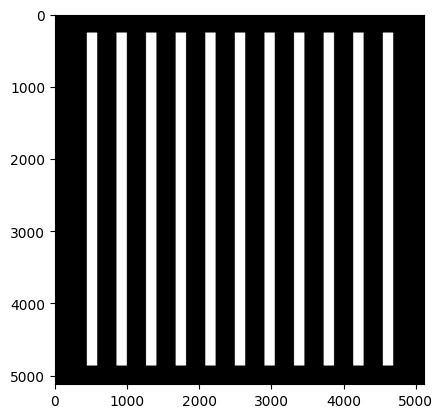

In [18]:
def generate_image(nx, ny, periods=6.25, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    # image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image = (image>=1) * 1.
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
plt.imshow(image, cmap='gray');

In [19]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'
output_filename = c.plot(z, image)
c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


In [20]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


H = 10.000 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_10.000_784a462c.png' 


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


H = 11.892 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_11.892_3909d292.png' 


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


H = 14.142 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_14.142_21227dce.png' 


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


H = 16.818 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_16.818_21319d52.png' 


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


H = 20.000 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_20.000_681cf358.png' 


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


H = 23.784 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_23.784_7b1090da.png' 


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


H = 28.284 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_28.284_e5f3e67e.png' 


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


H = 33.636 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_33.636_7561e551.png' 


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

H = 40.000 -> output_filename='2024-07-24_caustique/caustique_grating-image_H_40.000_140204a8.png' 


In [21]:
for threshold in np.linspace(0, 1, N_scan+2, endpoint=True)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


0.100 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.100_ef4b472a.png' 


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


0.200 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.200_21b96c33.png' 


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


0.300 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.300_a930bec9.png' 


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


0.400 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.400_88a562f1.png' 


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


0.500 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.500_f999bcd2.png' 


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


0.600 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.600_db03f147.png' 


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


0.700 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.700_221fa8d7.png' 


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


0.800 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.800_02695f59.png' 


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

0.900 -> output_filename='2024-07-24_caustique/caustique_grating-image_threshold=0.900_45da01db.png' 


In [22]:
for radius in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


radius=0.111 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.111_4cabe6db.png' 


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


radius=0.222 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.222_817fd394.png' 


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


radius=0.333 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.333_a0510b84.png' 


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


radius=0.444 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.444_62bfb655.png' 


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


radius=0.556 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.556_01812285.png' 


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


radius=0.667 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.667_1a5aada8.png' 


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


radius=0.778 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.778_f66d93ed.png' 


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


radius=0.889 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=0.889_a3f9a495.png' 


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

radius=1.000 -> output_filename='2024-07-24_caustique/caustique_grating-image_radius=1.000_e76caea3.png' 


In [23]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{periods=:.2e}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


periods=1.000 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=1.00e+00_a8d80f2e.png' 


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


periods=1.334 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=1.33e+00_c7ac651d.png' 


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


periods=1.778 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=1.78e+00_204af4c1.png' 


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


periods=2.371 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=2.37e+00_35298f76.png' 


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


periods=3.162 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=3.16e+00_5dd1a7cd.png' 


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


periods=4.217 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=4.22e+00_0801226e.png' 


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


periods=5.623 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=5.62e+00_8c8e8a2a.png' 


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


periods=7.499 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=7.50e+00_7e51e58c.png' 


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

periods=10.000 -> output_filename='2024-07-24_caustique/caustique_grating-image_periods=1.00e+01_469dfca1.png' 


In [24]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'gamma', 'min_lum', 'zmin']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        z = c.wave()
        image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
        output_filename = c.plot(z, image)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


scale=scale(default)*0.500=4.352E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.500_a13a0f8e.png'


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


scale=scale(default)*0.595=5.175E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.595_d13b1441.png'


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


scale=scale(default)*0.707=6.155E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.707_7b95187e.png'


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


scale=scale(default)*0.841=7.319E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_0.841_c7477141.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


scale=scale(default)*1.000=8.704E+02 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.000_07eddf45.png'


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


scale=scale(default)*1.189=1.035E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.189_91183d43.png'


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


scale=scale(default)*1.414=1.231E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.414_7561f818.png'


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


scale=scale(default)*1.682=1.464E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_1.682_d3a01cd1.png'


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


scale=scale(default)*2.000=1.741E+03 -> output_filename='2024-07-24_caustique/caustique_scale_modul_2.000_c38acc44.png'
======B_sf======


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


B_sf=B_sf(default)*0.500=6.250E-01 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.500_2e25c9c6.png'


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


B_sf=B_sf(default)*0.595=7.433E-01 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.595_680311d9.png'


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


B_sf=B_sf(default)*0.707=8.839E-01 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.707_59ce4d32.png'


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


B_sf=B_sf(default)*0.841=1.051E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_0.841_a3f5b12f.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


B_sf=B_sf(default)*1.000=1.250E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.000_5b595f4c.png'


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


B_sf=B_sf(default)*1.189=1.487E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.189_f2cc2bb1.png'


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


B_sf=B_sf(default)*1.414=1.768E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.414_df5a9ab1.png'


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


B_sf=B_sf(default)*1.682=2.102E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_1.682_df7d7055.png'


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


B_sf=B_sf(default)*2.000=2.500E+00 -> output_filename='2024-07-24_caustique/caustique_B_sf_modul_2.000_46aa158d.png'
======theta======


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


theta=theta(default)*0.500=7.854E-01 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.500_797ee560.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


theta=theta(default)*0.595=9.340E-01 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.595_57ef1765.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


theta=theta(default)*0.707=1.111E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.707_c728cd2a.png'


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


theta=theta(default)*0.841=1.321E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_0.841_f7950331.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


theta=theta(default)*1.000=1.571E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.000_9338e312.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


theta=theta(default)*1.189=1.868E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.189_6066711f.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


theta=theta(default)*1.414=2.221E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.414_0c6f7927.png'


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


theta=theta(default)*1.682=2.642E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_1.682_fea7a4df.png'


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


theta=theta(default)*2.000=3.142E+00 -> output_filename='2024-07-24_caustique/caustique_theta_modul_2.000_cf5d5ab6.png'
======B_theta======


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


B_theta=B_theta(default)*0.500=5.236E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.500_c026242c.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


B_theta=B_theta(default)*0.595=6.227E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.595_5f1f01bc.png'


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


B_theta=B_theta(default)*0.707=7.405E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.707_4f4ac9ea.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


B_theta=B_theta(default)*0.841=8.806E-01 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_0.841_e219eec0.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


B_theta=B_theta(default)*1.000=1.047E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.000_363867b2.png'


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


B_theta=B_theta(default)*1.189=1.245E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.189_ffe819cf.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


B_theta=B_theta(default)*1.414=1.481E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.414_828c9bbb.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


B_theta=B_theta(default)*1.682=1.761E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_1.682_4b40e085.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


B_theta=B_theta(default)*2.000=2.094E+00 -> output_filename='2024-07-24_caustique/caustique_B_theta_modul_2.000_add66392.png'
======gamma======


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


gamma=gamma(default)*0.500=1.200E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.500_49f79e4c.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


gamma=gamma(default)*0.595=1.427E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.595_71396ff5.png'


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


gamma=gamma(default)*0.707=1.697E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.707_b6d698fb.png'


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


gamma=gamma(default)*0.841=2.018E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_0.841_2faf2034.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


gamma=gamma(default)*1.000=2.400E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.000_a5a0d8ca.png'


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


gamma=gamma(default)*1.189=2.854E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.189_f658bd09.png'


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


gamma=gamma(default)*1.414=3.394E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.414_568cf5fe.png'


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


gamma=gamma(default)*1.682=4.036E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_1.682_af7134f6.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


gamma=gamma(default)*2.000=4.800E+00 -> output_filename='2024-07-24_caustique/caustique_gamma_modul_2.000_ed8fc44b.png'
======min_lum======


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


min_lum=min_lum(default)*0.500=5.000E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.500_dbef85a5.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


min_lum=min_lum(default)*0.595=5.946E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.595_8e7ae54b.png'


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


min_lum=min_lum(default)*0.707=7.071E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.707_aa550a41.png'


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


min_lum=min_lum(default)*0.841=8.409E-02 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_0.841_c29c6e37.png'


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


min_lum=min_lum(default)*1.000=1.000E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.000_f1d0bdab.png'


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


min_lum=min_lum(default)*1.189=1.189E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.189_5cd543a2.png'


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


min_lum=min_lum(default)*1.414=1.414E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.414_88fc2b4a.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


min_lum=min_lum(default)*1.682=1.682E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_1.682_20ce93a6.png'


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


min_lum=min_lum(default)*2.000=2.000E-01 -> output_filename='2024-07-24_caustique/caustique_min_lum_modul_2.000_ecf47e0c.png'
======zmin======


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


zmin=zmin(default)*0.500=1.000E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.500_fb8bb25a.png'


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


zmin=zmin(default)*0.595=1.189E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.595_3ca3d201.png'


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


zmin=zmin(default)*0.707=1.414E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.707_bf3c0e8d.png'


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


zmin=zmin(default)*0.841=1.682E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_0.841_f06ad317.png'


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


zmin=zmin(default)*1.000=2.000E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.000_5a2642d1.png'


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


zmin=zmin(default)*1.189=2.378E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.189_bf52ece1.png'


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


zmin=zmin(default)*1.414=2.828E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.414_5646fe1e.png'


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


zmin=zmin(default)*1.682=3.364E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_1.682_60a57eb1.png'


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

zmin=zmin(default)*2.000=4.000E-01 -> output_filename='2024-07-24_caustique/caustique_zmin_modul_2.000_1b0aa246.png'


## shining a grid image to the wave

In [25]:
type = 'grid'

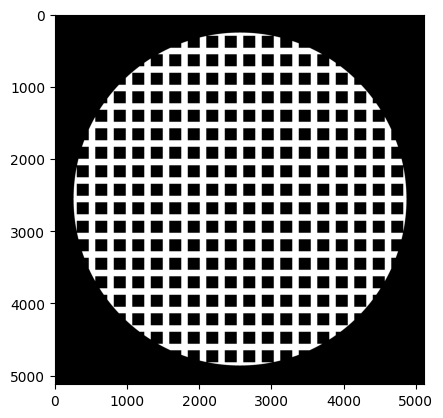

In [26]:
def generate_image(nx, ny, periods=10, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    image = (image>=1) * 1.
    image *= ((X**2 + Y**2) < radius**2) * 1.
    return image
    
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=10, threshold=0.45, radius=.9)
plt.imshow(image, cmap='gray');

In [27]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'

output_filename = c.plot(z, image)
c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


In [28]:
for threshold in np.linspace(0, 1, N_scan+2, endpoint=True)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=10, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


threshold=0.100 -> output_filename='2024-07-24_caustique/caustique_grid-image_threshold=0.100_742a7cfa.png' 


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


threshold=0.200 -> output_filename='2024-07-24_caustique/caustique_grid-image_threshold=0.200_6718c7c4.png' 


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


threshold=0.300 -> output_filename='2024-07-24_caustique/caustique_grid-image_threshold=0.300_2aec17f2.png' 


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


threshold=0.400 -> output_filename='2024-07-24_caustique/caustique_grid-image_threshold=0.400_bd251189.png' 


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{periods=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods, threshold=.2)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

## shining a hole image to the wave

In [ ]:
type = 'hole'

In [ ]:
def generate_image(nx, ny, periods=6.5, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    image = 1. - (image<=1)
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=6.5, threshold=0.45, radius=.9)
plt.imshow(image, cmap='gray');

In [ ]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'

output_filename = c.plot(z, image)
c.show(output_filename)

In [ ]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for threshold in np.linspace(0, 1, N_scan+2, endpoint=True)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=6.5, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{periods=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods, threshold=.2)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

## shining a square image to the wave

In [ ]:
type = 'square'

In [ ]:
def generate_image(nx, ny,  radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=.9)
plt.imshow(image, cmap='gray');

In [ ]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [ ]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for radius in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

## shining a disk image to the wave

In [ ]:
type = 'disk'

In [ ]:
def generate_image(nx, ny, radius_in=0., radius_out=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = ((X**2 + Y**2) < radius_out**2) * ((X**2 + Y**2) > radius_in**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_out=.9)
plt.imshow(image, cmap='gray');

In [ ]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [ ]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for radius_out in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius_out=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_out=radius_out)
    output_filename = c.plot(z, image)
    print(f'{radius_out:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for radius_in in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius_in=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_in=radius_in)
    output_filename = c.plot(z, image)
    print(f'{radius_in=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

## shining a bi-grating image to the wave

In [ ]:
def generate_image(nx, ny, period1=2, period2=64, threshold=0.3, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image  = (np.cos(2*np.pi*X*period1) > threshold) * 1.
    image *= np.cos(2*np.pi*X*period2) > threshold
    image *= (X**2 < radius**2) * (Y**2 < radius**2)
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
plt.imshow(image, cmap='gray');

In [ ]:
type = 'bigrating'
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [ ]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for threshold in np.linspace(0, 1, N_scan+2, endpoint=True)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for radius in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for period1 in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{period1=:.2e}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, period1=period1)
    output_filename = c.plot(z, image)
    print(f'{period1=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

In [ ]:
for period2 in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{period2=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, period2=period2)
    output_filename = c.plot(z, image)
    print(f'{period2=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)